# Orthogonal Matching Pursuit (OMP)

### Restore Variable 

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
mat = io.loadmat('temp.mat')

H = mat['H']
Wopt = mat['Wopt']
Fopt = mat['Fopt']
Ns = mat['Ns'][0,0]
Nt = mat['Nt'][0,0]
Nr = mat['Nr'][0,0]
Nc = mat['Nc'][0,0]
Nray = mat['Nray'][0,0]
realization = mat['realization'][0,0]
At = mat['At']
Ar = mat['Ar']
print(H.shape)

(36, 144, 1000)


In [20]:
print(H[8,8,8])

(0.643956557994+1.18650766592j)


### Calculate FRF, FBB by OMP algorithm

In [3]:
def OMP(_Fopt,_NRF,_At):
    _FRF = np.empty((_At.shape[0],0))
    _Fres = _Fopt
    for k in range(_NRF):
        PU = _At.conj().T@_Fres
        ind = np.argmax(np.sum((np.absolute(PU))**2,axis=1))
        _FRF = np.append(_FRF,_At[:,[ind]],axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
    return _FRF,_FBB


### Plot Spectral Efficiency with Precoder and Combiner getting from OMP

In [4]:
NRF = 3
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R = np.zeros([smax, realization],dtype=complex)
R_o = np.zeros([smax, realization],dtype=complex)

for reali in range(realization):
    FRF, FBB = OMP( Fopt[:,:,reali], NRF, At[:,:,reali] )
    FBB = np.sqrt(Ns)*FBB/np.linalg.norm(FRF@FBB,'fro')
    WRF, WBB = OMP( Wopt[:,:,reali], NRF, Ar[:,:,reali])
    for s in range(smax):
        R[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(WRF@WBB)@H[:,:,reali]@FRF@FBB@FBB.conj().T@FRF.conj().T@H[:,:,reali].conj().T@WRF@WBB))
        R_o[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(Wopt[:,:,reali])@H[:,:,reali]@Fopt[:,:,reali]@Fopt[:,:,reali].conj().T@H[:,:,reali].conj().T@Wopt[:,:,reali]))


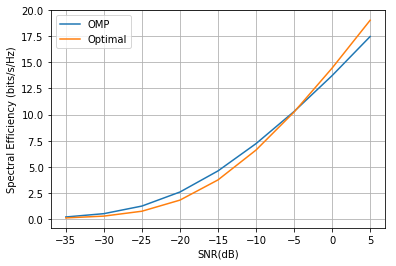

In [5]:
plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')
plt.plot(SNR_dB, (np.sum(R_o,axis=1).real)/realization, label='Optimal')
plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()